In [10]:
from ucimlrepo import fetch_ucirepo 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer

In [11]:
bank_marketing = fetch_ucirepo(id=222) 

In [12]:
df = bank_marketing.data.original
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


### 3) Làm sạch cơ bản và kiểm tra giá trị null

In [13]:
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)


Numeric: ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']
Categorical: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


In [14]:
missing_df = df.isna().sum().sort_values(ascending=False).reset_index()
missing_df.columns = ["feature", "missing_count"]
missing_df[missing_df["missing_count"]>0]

,feature,missing_count
0,poutcome,36959
1,contact,13020
2,education,1857
3,job,288


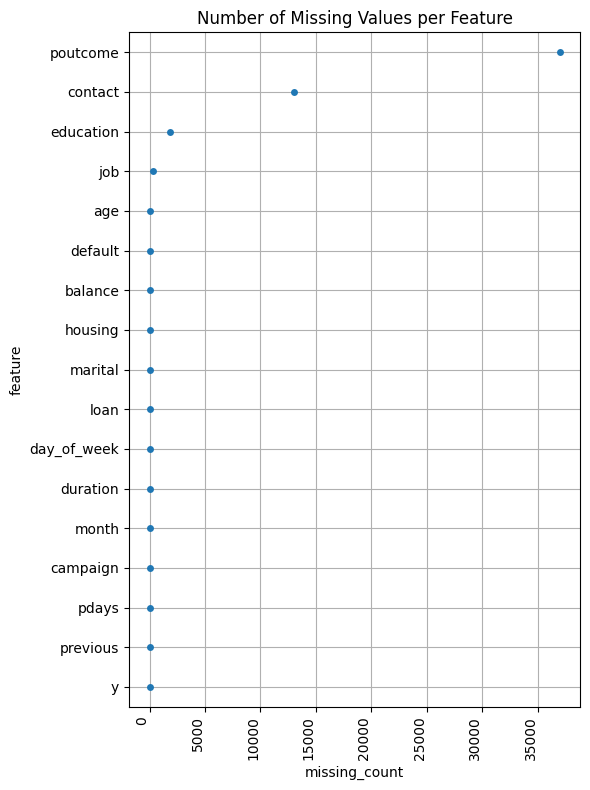

In [15]:
plt.figure(figsize=(6, 8))
sns.stripplot(
    y="feature",
    x="missing_count",
    data=missing_df
)
plt.title("Number of Missing Values per Feature")
plt.xticks(rotation=90, ha="right")
plt.grid(True)
plt.tight_layout()
plt.show()


Kiểm tra giá trị unique của các cột có missing: missing xuất hiện ở các biến phân loại, và là NaN thật

In [16]:
for col in ["poutcome", "contact", "education", "job"]:
    print(col, df[col].unique())

poutcome [nan 'failure' 'other' 'success']
contact [nan 'cellular' 'telephone']
education ['tertiary' 'secondary' nan 'primary']
job ['management' 'technician' 'entrepreneur' 'blue-collar' nan 'retired'
 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid' 'student']


Kiểm tra logic nghiệp vụ giữa previous, pdays, poutcome:  Nếu chưa từng có campaign trước → không thể có kết quả campaign trước (previous = 0 --> poutcome = NaN)

In [17]:
df[["previous","pdays","poutcome","y"]].head()

,previous,pdays,poutcome,y
0,0,-1,NaN,no
1,0,-1,NaN,no
2,0,-1,NaN,no
3,0,-1,NaN,no
4,0,-1,NaN,no


Tạo biến đánh dấu missing của poutcome/ dùng để phân tích

In [18]:
df["poutcome_missing"] = df["poutcome"].isna().astype(int)

Kiểm tra mối liên hệ giữa missing và previous:

In [19]:
pd.crosstab(df["poutcome_missing"], df["previous"] > 0, normalize="index")

previous,False,True
poutcome_missing,,
0,0.000000,1.000000
1,0.999865,0.000135


So sánh tỷ lệ đăng ký giữa nhóm missing vs non-missing: Missing ảnh hưởng rõ rệt đến target 

In [20]:
df["target"] = (df["y"] == "yes").astype(int)
df.groupby(df["poutcome"].isna())["target"].mean()

poutcome
False    0.230611
True     0.091615
Name: target, dtype: float64

Xử lý sơ giá trị


In [21]:
df["poutcome"] = df["poutcome"].fillna("no_previous_campaign")
df["pdays_contacted"] = (~df["pdays"].isin([-1, 999])).astype(int)
df["has_previous_campaign"] = (df["previous"] > 0).astype(int)

In [22]:
df[df['pdays'] == 999]['pdays']

Series([], Name: pdays, dtype: int64)

In [23]:
df["target"] = (df["y"] == "yes").astype(int)

df.groupby("poutcome")["target"].mean().sort_values(ascending=False)


poutcome
success                 0.647253
other                   0.166848
failure                 0.126097
no_previous_campaign    0.091615
Name: target, dtype: float64

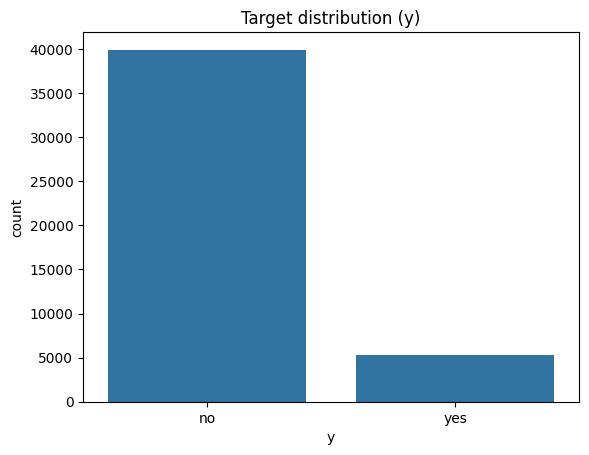

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

In [24]:
sns.countplot(x="y", data=df)
plt.title("Target distribution (y)")
plt.show()
df["y"].value_counts(normalize=True)

In [25]:
df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day_of_week,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


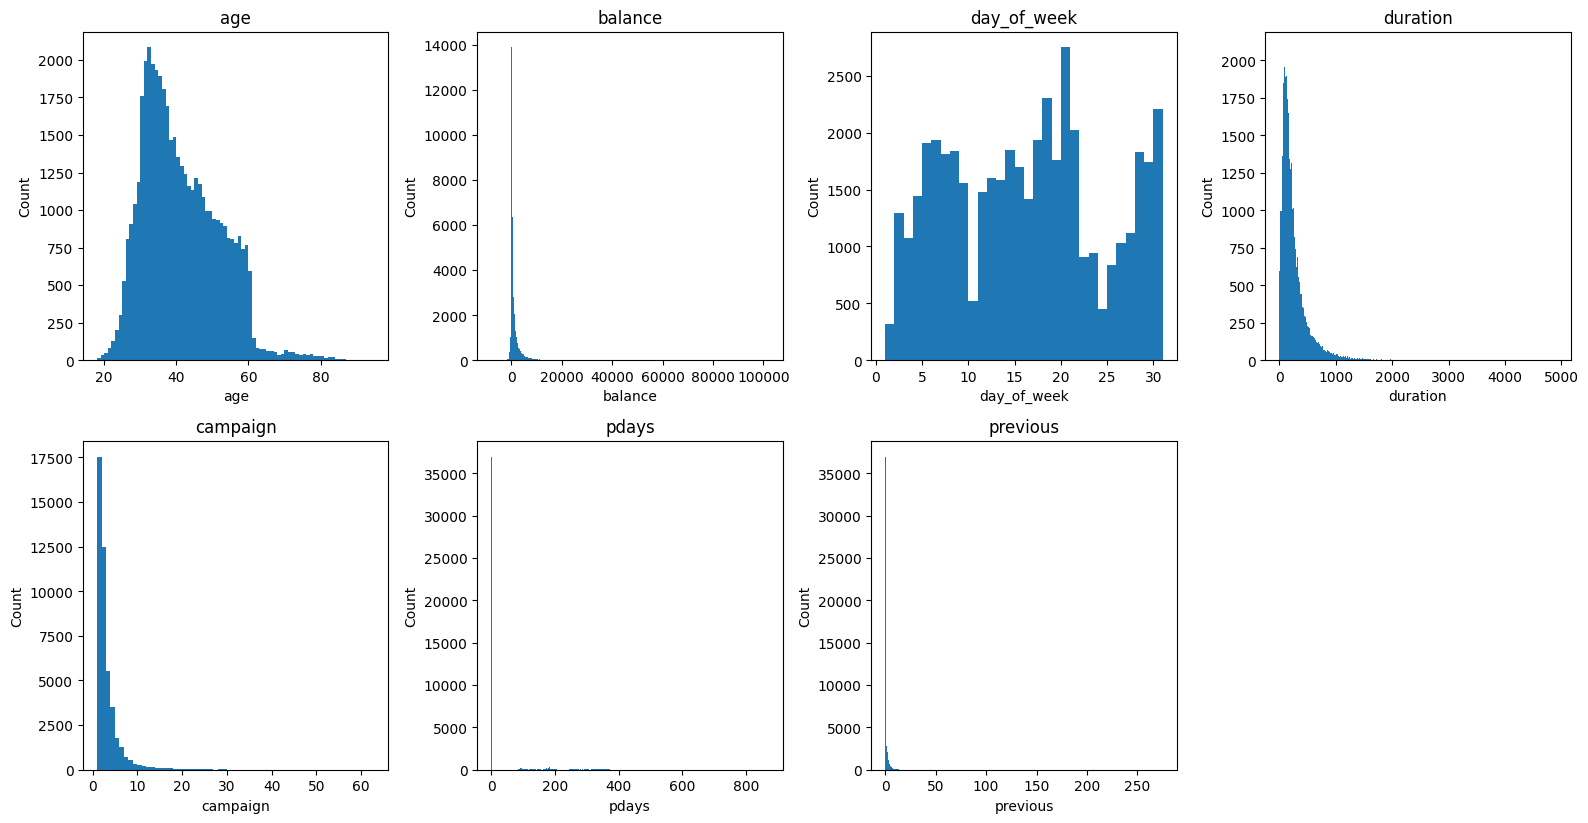

In [26]:
plt.figure(figsize=(16, 12))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 4, i)
    plt.hist(df[col], bins="auto")
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


**Outlier Analysis:**  
- Nhiều biến số trong dữ liệu xuất hiện các giá trị bị coi là outlier theo tiêu chí thống kê (IQR).  
- Tuy nhiên, các outlier này phản ánh hành vi thực tế của khách hàng ngân hàng (ví dụ: số dư lớn, thời lượng cuộc gọi dài, số lần liên hệ nhiều) và không phải là lỗi dữ liệu 

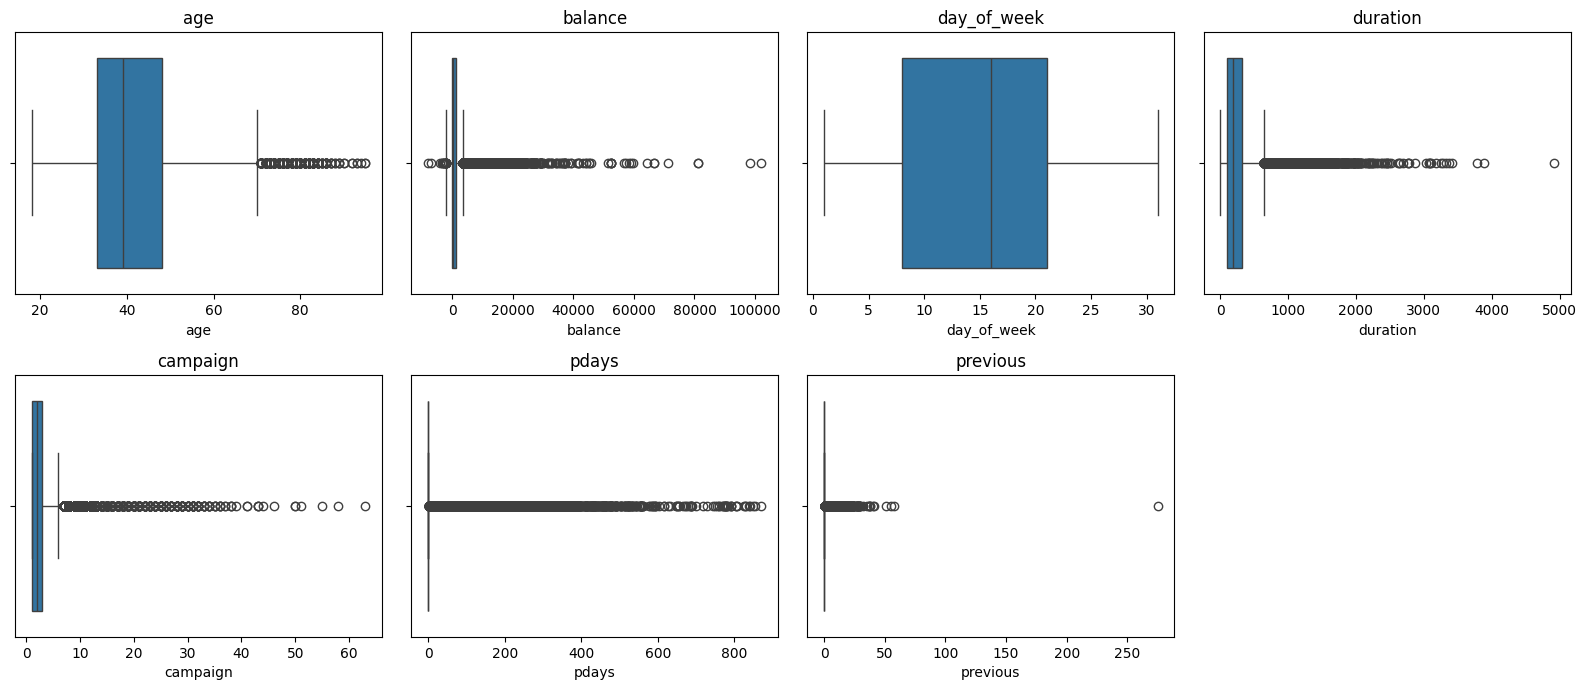

In [27]:
plt.figure(figsize=(16, 10))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

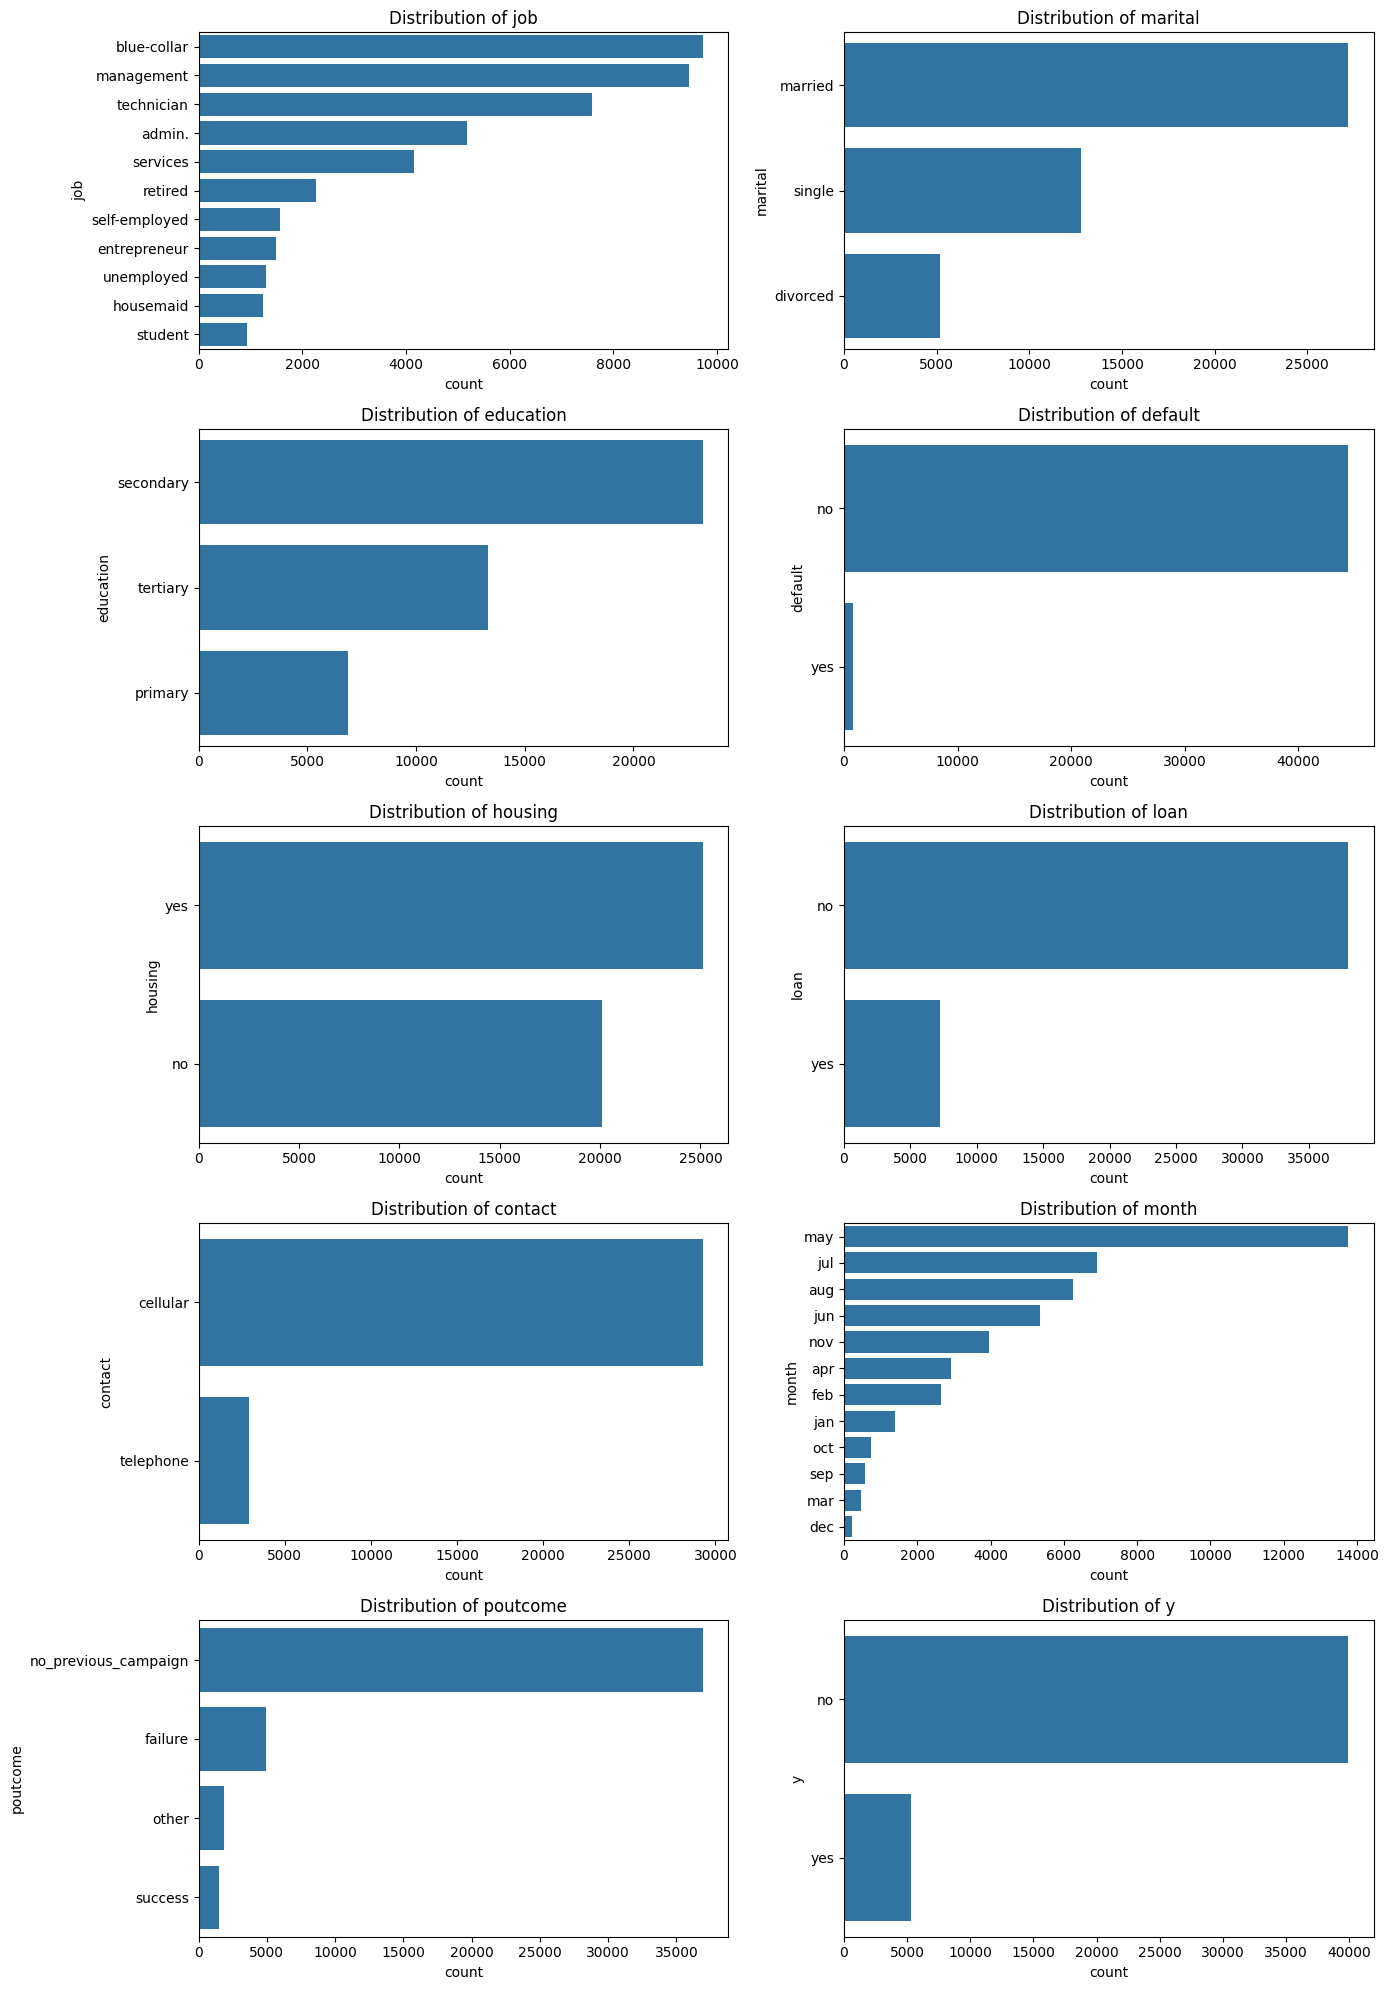

In [28]:
n_cols = 2
n_rows = math.ceil(len(categorical_cols) / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(14, 4 * n_rows)
)

axes = axes.flatten()

for ax, col in zip(axes, categorical_cols):
    sns.countplot(
        y=col,
        data=df,
        order=df[col].value_counts().index,
        ax=ax
    )
    ax.set_title(f"Distribution of {col}")

for i in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


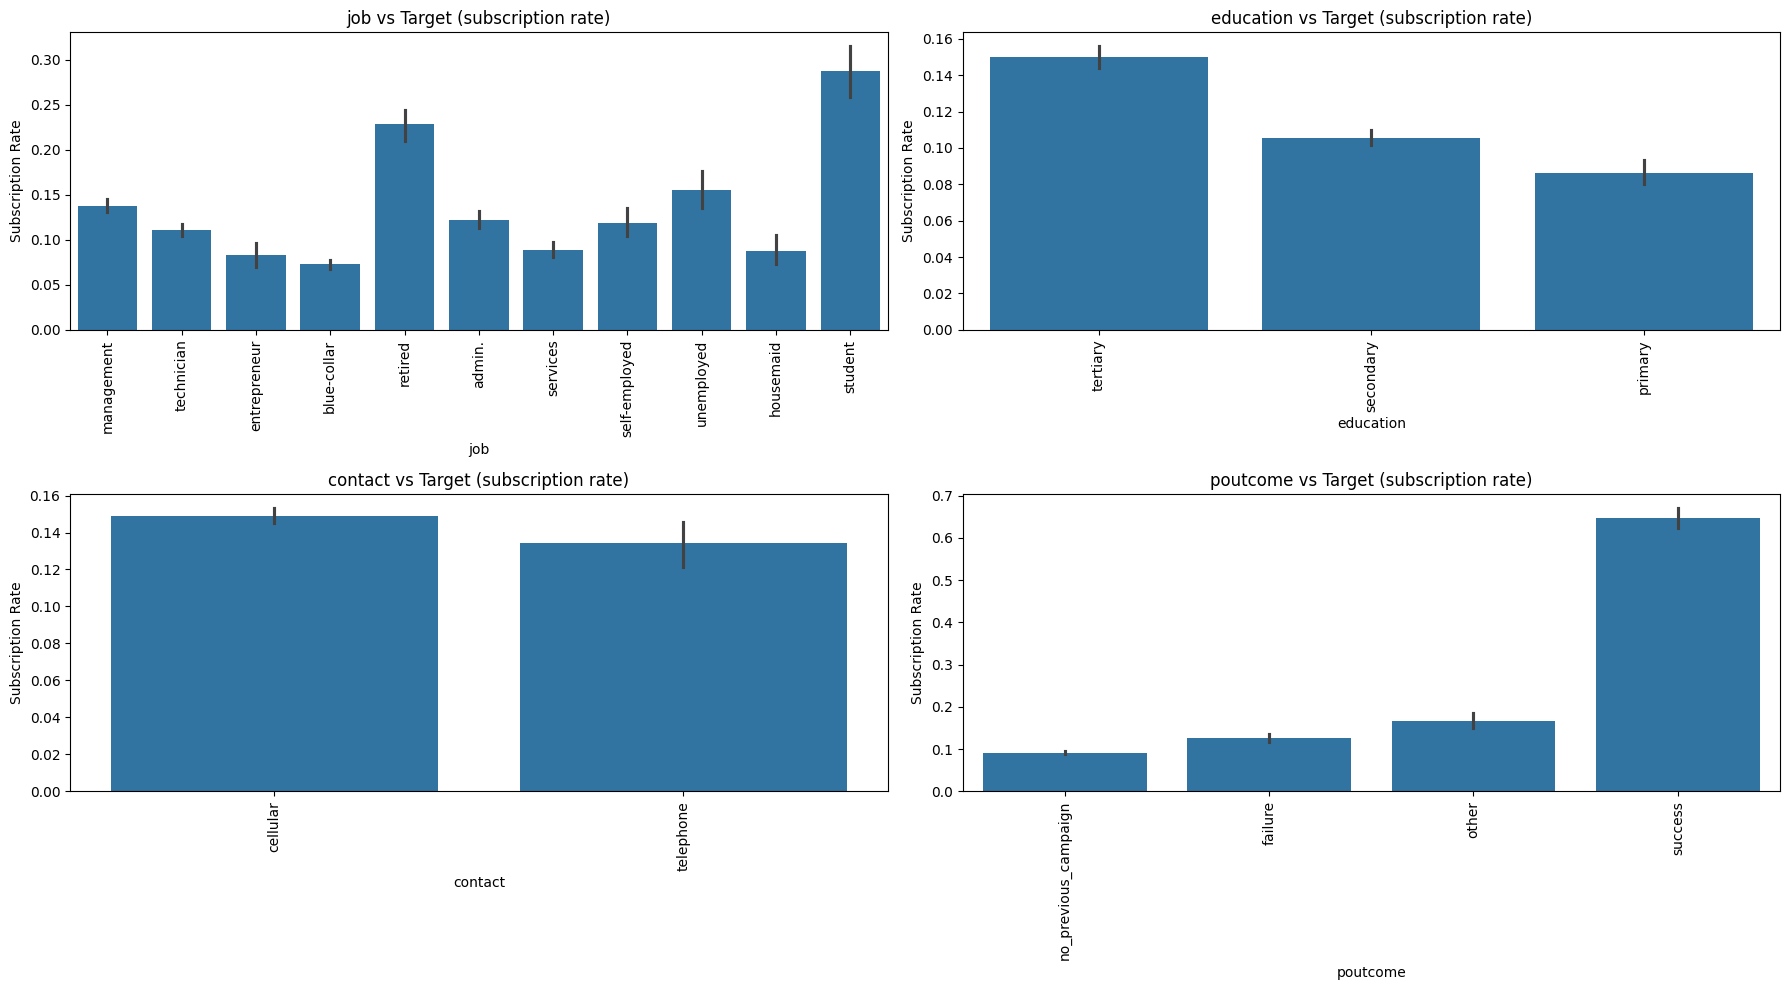

In [29]:
cols = ["job", "education", "contact", "poutcome"]

fig, axes = plt.subplots(
    nrows=2, ncols=2,
    figsize=(18, 10)
)

axes = axes.flatten()

for ax, col in zip(axes, cols):
    sns.barplot(
        x=col,
        y=(df["y"] == "yes").astype(int),
        data=df,
        ax=ax
    )
    ax.set_title(f"{col} vs Target (subscription rate)")
    ax.set_xlabel(col)
    ax.set_ylabel("Subscription Rate")
    ax.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()


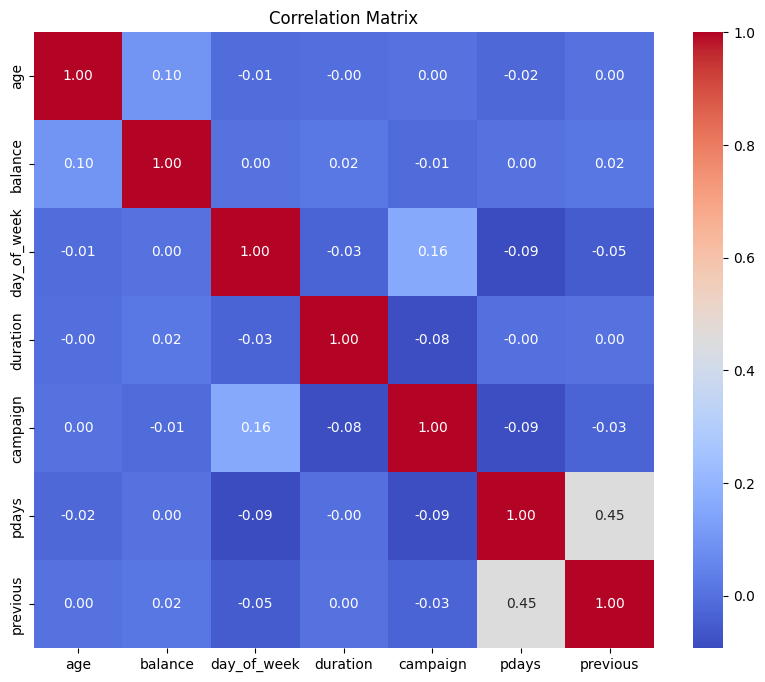

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


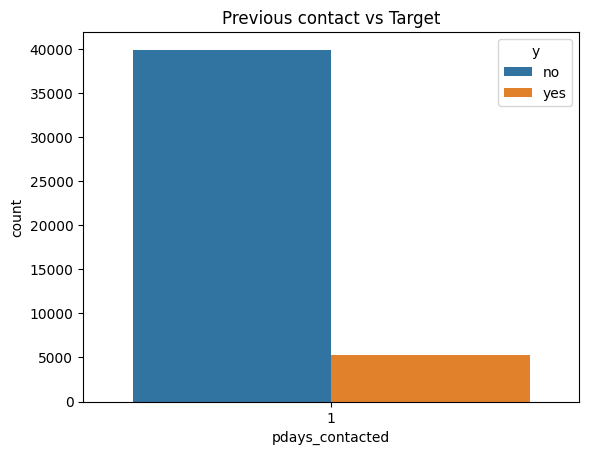

In [31]:
df["pdays_contacted"] = (df["pdays"] != 999).astype(int)

sns.countplot(x="pdays_contacted", hue="y", data=df)
plt.title("Previous contact vs Target")
plt.show()


In [32]:
df.to_csv("../data/processed/bank_marketing_raw.csv", index=False)
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y', 'poutcome_missing', 'target',
       'pdays_contacted', 'has_previous_campaign'],
      dtype='object')

### Preprocessing

In [33]:
#Biến có dấu hiệu leakage 
df = df.drop(columns=['duration'])

In [34]:
#distribution của biến y 
df["y"].value_counts(normalize=True)

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

Mất cân bằng lớp (Class Imbalance). Tỷ lệ no thường chiếm khoảng 88.7% và yes chỉ khoảng 11.3%.

Hệ quả: Accuracy sẽ không tin cậy. Cần dùng F1-score, Precision/Recall hoặc AUC-ROC.

In [35]:
#Xử lý nan
cols = ["poutcome", "contact", "education", "job"]

df[cols] = (
    df[cols]
    .replace(["nan", "NaN", "None", ""], pd.NA)
    .fillna("unknown")
)
for col in cols:
    print(col, df[col].unique())


poutcome ['no_previous_campaign' 'failure' 'other' 'success']
contact ['unknown' 'cellular' 'telephone']
education ['tertiary' 'secondary' 'unknown' 'primary']
job ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']


In [36]:
#Có 16 giá trị trùng lặp 
df.duplicated().value_counts()
df = df.drop_duplicates()

In [37]:
df["pdays_contacted"] = (~df["pdays"].isin([-1, 999])).astype(int)
df["pdays_contacted"].value_counts()

pdays_contacted
0    36938
1     8257
Name: count, dtype: int64

In [38]:
df["day_of_week"].head()
df["day_of_week"].min(), df["day_of_week"].max()
df = df.rename(columns={"day_of_week": "day"})

In [39]:
numeric_cols = ['age','balance','day','campaign','pdays','previous','poutcome_missing','pdays_contacted','has_previous_campaign']
categorical_cols = ['job','marital','education','default','housing','loan','contact','month','poutcome']

In [40]:
#Xử lý mất câng bằng
from sklearn.model_selection import train_test_split


X = df[categorical_cols + numeric_cols].copy()
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Feature Engineering

Pipeline A — Cho model cần scale (LogReg / SVM / KNN / MLP)

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
import numpy as np

def build_smote_components(cat_cols, num_cols, skew_cols, *, k_neighbors=5, random_state=42):
    def clip_and_log(X):
        X = X.astype(float)
        lo = np.nanpercentile(X, 1, axis=0)
        hi = np.nanpercentile(X, 99, axis=0)
        X = np.clip(X, lo, hi)
        return np.log1p(np.maximum(X, 0))

    def signed_log1p(X):
        X = X.astype(float)
        lo = np.nanpercentile(X, 1, axis=0)
        hi = np.nanpercentile(X, 99, axis=0)
        X = np.clip(X, lo, hi)
        return np.sign(X) * np.log1p(np.abs(X))

    skew_signed = [c for c in skew_cols if c == "balance" and c in num_cols]
    skew_pos = [c for c in skew_cols if c != "balance" and c in num_cols]
    rest_num = [c for c in num_cols if c not in set(skew_signed + skew_pos)]

    # PRE: cat ordinal (kỹ thuật cho SMOTENC), num log/scale
    pre = []
    pre.append((
        "cat_ord",
        Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
        ]),
        cat_cols
    ))

    if skew_pos:
        pre.append((
            "num_skew_pos",
            Pipeline([
                ("imp", SimpleImputer(strategy="median")),
                ("log", FunctionTransformer(clip_and_log, feature_names_out="one-to-one")),
                ("sc", RobustScaler()),
            ]),
            skew_pos
        ))

    if skew_signed:
        pre.append((
            "num_skew_signed",
            Pipeline([
                ("imp", SimpleImputer(strategy="median")),
                ("log", FunctionTransformer(signed_log1p, feature_names_out="one-to-one")),
                ("sc", RobustScaler()),
            ]),
            skew_signed
        ))

    if rest_num:
        pre.append((
            "num_rest",
            Pipeline([
                ("imp", SimpleImputer(strategy="median")),
                ("sc", RobustScaler()),
            ]),
            rest_num
        ))

    pre_smote = ColumnTransformer(pre, remainder="drop")

    # cat nằm trước => indices 0..len(cat_cols)-1
    cat_idx = list(range(len(cat_cols)))

    smote = SMOTENC(
        categorical_features=cat_idx,
        k_neighbors=k_neighbors,
        random_state=random_state
    )

    # POST: onehot cat + giữ nguyên num đã scale
    post = ColumnTransformer(
        transformers=[
            ("cat_oh", OneHotEncoder(handle_unknown="ignore"), cat_idx),
            ("num_passthrough", "passthrough", slice(len(cat_cols), None)),
        ],
        remainder="drop"
    )

    return pre_smote, smote, post


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline

skew_cols = ["balance", "campaign", "pdays", "previous"]
#Ví dụ thôi 

pre_smote, smote, post = build_smote_components(
    categorical_cols, numeric_cols, skew_cols,
    k_neighbors=5, random_state=42
)

clf_smote_lr = ImbPipeline(steps=[
    ("pre_smote", pre_smote),
    ("smote", smote),
    ("post", post),
    ("model", LogisticRegression(max_iter=5000))
])

clf_smote_lr.fit(X_train, y_train)
proba = clf_smote_lr.predict_proba(X_test)[:, 1]

print("SMOTE-NC + LR | PR-AUC:", average_precision_score(y_test, proba))
print("SMOTE-NC + LR | ROC-AUC:", roc_auc_score(y_test, proba))


SMOTE-NC + LR | PR-AUC: 0.3785346233638166
SMOTE-NC + LR | ROC-AUC: 0.7415714874812557


In [44]:
#classweight
def make_preprocess_scaled(cat_cols, num_cols, skew_cols):
    def clip_and_log(X):
        X = X.astype(float)
        lo = np.nanpercentile(X, 1, axis=0)
        hi = np.nanpercentile(X, 99, axis=0)
        X = np.clip(X, lo, hi)
        return np.log1p(np.maximum(X, 0))  # dành cho biến không âm

    def signed_log1p(X):
        X = X.astype(float)
        lo = np.nanpercentile(X, 1, axis=0)
        hi = np.nanpercentile(X, 99, axis=0)
        X = np.clip(X, lo, hi)
        return np.sign(X) * np.log1p(np.abs(X))

    skew_signed = [c for c in skew_cols if c == "balance" and c in num_cols]
    skew_pos = [c for c in skew_cols if c != "balance" and c in num_cols]

    transformers = []

    if skew_pos:
        transformers.append((
            "num_skew_pos",
            Pipeline([
                ("imp", SimpleImputer(strategy="median")),
                ("log", FunctionTransformer(clip_and_log, feature_names_out="one-to-one")),
                ("sc", RobustScaler()),
            ]),
            skew_pos
        ))

    if skew_signed:
        transformers.append((
            "num_skew_signed",
            Pipeline([
                ("imp", SimpleImputer(strategy="median")),
                ("log", FunctionTransformer(signed_log1p, feature_names_out="one-to-one")),
                ("sc", RobustScaler()),
            ]),
            skew_signed
        ))

    rest_num = [c for c in num_cols if c not in set(skew_pos + skew_signed)]
    if rest_num:
        transformers.append((
            "num_rest",
            Pipeline([
                ("imp", SimpleImputer(strategy="median")),
                ("sc", RobustScaler()),
            ]),
            rest_num
        ))

    transformers.append((
        "cat",
        Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore")),
        ]),
        cat_cols
    ))

    return ColumnTransformer(transformers=transformers, remainder="drop")


In [45]:
skew_cols = ["balance", "campaign", "pdays", "previous"]  

prep_scaled = make_preprocess_scaled(categorical_cols, numeric_cols, skew_cols)

clf_lr_cw = Pipeline(steps=[
    ("prep", prep_scaled),
    ("model", LogisticRegression(max_iter=5000, class_weight="balanced"))
])

clf_lr_cw.fit(X_train, y_train)
proba = clf_lr_cw.predict_proba(X_test)[:, 1]

print("LR + class_weight | PR-AUC:", average_precision_score(y_test, proba))
print("LR + class_weight | ROC-AUC:", roc_auc_score(y_test, proba))


LR + class_weight | PR-AUC: 0.4077508753907927
LR + class_weight | ROC-AUC: 0.774443983098801


(RF / GBDT / XGBoost…)

In [46]:
#Hàm preprocessing khi dùng smote
def build_tree_smote_components(cat_cols, num_cols, *, k_neighbors=5, random_state=42):
    def clip_only(X):
        X = X.astype(float)
        lo = np.nanpercentile(X, 1, axis=0)
        hi = np.nanpercentile(X, 99, axis=0)
        return np.clip(X, lo, hi)

    # PRE-SMOTE: cat -> ordinal (kỹ thuật), num -> impute + clip
    pre_smote = ColumnTransformer(
        transformers=[
            ("cat_ord", Pipeline([
                ("imp", SimpleImputer(strategy="most_frequent")),
                ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
            ]), cat_cols),
            ("num", Pipeline([
                ("imp", SimpleImputer(strategy="median")),
                ("clip", FunctionTransformer(clip_only, feature_names_out="one-to-one")),
            ]), num_cols),
        ],
        remainder="drop"
    )

    # cat indices là [0..len(cat_cols)-1] vì cat đặt trước num
    cat_idx = list(range(len(cat_cols)))

    smote = SMOTENC(
        categorical_features=cat_idx,
        k_neighbors=k_neighbors,
        random_state=random_state
    )

    # POST-SMOTE: onehot cat + passthrough num
    post = ColumnTransformer(
        transformers=[
            ("cat_oh", OneHotEncoder(handle_unknown="ignore"), cat_idx),
            ("num_passthrough", "passthrough", slice(len(cat_cols), None)),
        ],
        remainder="drop"
    )

    return pre_smote, smote, post


In [47]:
#ví dụ để test
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, roc_auc_score

pre_smote, smote, post = build_tree_smote_components(
    categorical_cols, numeric_cols, k_neighbors=5, random_state=42
)

clf_tree_smote = ImbPipeline(steps=[
    ("pre_smote", pre_smote),
    ("smote", smote),
    ("post", post),
    ("model", RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1
    ))
])

clf_tree_smote.fit(X_train, y_train)
proba = clf_tree_smote.predict_proba(X_test)[:, 1]

print("Tree + SMOTE-NC | PR-AUC:", average_precision_score(y_test, proba))
print("Tree + SMOTE-NC | ROC-AUC:", roc_auc_score(y_test, proba))


Tree + SMOTE-NC | PR-AUC: 0.39213653833495277
Tree + SMOTE-NC | ROC-AUC: 0.7896515921911894


In [48]:
def make_preprocess_tree(cat_cols, num_cols):
    def clip_only(X):
        X = X.astype(float)
        lo = np.nanpercentile(X, 1, axis=0)
        hi = np.nanpercentile(X, 99, axis=0)
        return np.clip(X, lo, hi)

    return ColumnTransformer(
        transformers=[
            ("num",
             Pipeline([
                 ("imp", SimpleImputer(strategy="median")),
                 ("clip", FunctionTransformer(clip_only, feature_names_out="one-to-one")),
             ]),
             num_cols),
            ("cat",
             Pipeline([
                 ("imp", SimpleImputer(strategy="most_frequent")),
                 ("oh", OneHotEncoder(handle_unknown="ignore")),
             ]),
             cat_cols),
        ],
        remainder="drop"
    )


In [49]:
#class_weight:
pre_tree = make_preprocess_tree(categorical_cols, numeric_cols)

clf_tree_cw = Pipeline(steps=[
    ("prep", pre_tree),
    ("model", RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample" #cnay cho random_forest , có gì đổi cho phù hợp với thuật toán nha
        # hoặc "balanced"
    ))
])

clf_tree_cw.fit(X_train, y_train)
proba = clf_tree_cw.predict_proba(X_test)[:, 1]

print("Tree + class_weight | PR-AUC:", average_precision_score(y_test, proba))
print("Tree + class_weight | ROC-AUC:", roc_auc_score(y_test, proba))


Tree + class_weight | PR-AUC: 0.4242439059131936
Tree + class_weight | ROC-AUC: 0.7916343257580799


## Logistic Regression

In [72]:
from dotenv import load_dotenv
import os
import random
import numpy as np
import mlflow
import mlflow.sklearn

# Load env
load_dotenv()

print("MLflow URI:", os.getenv("MLFLOW_TRACKING_URI"))

# Set seed (tái lập kết quả)
random.seed(42)
np.random.seed(42)

# MLflow setup
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI"))
mlflow.set_experiment("train_logistic")


MLflow URI: https://mlflow.thonph.site/


<Experiment: artifact_location='s3://mlflow/artifacts/28', creation_time=1766732807446, experiment_id='28', last_update_time=1766732807446, lifecycle_stage='active', name='train_logistic', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


In [74]:
def evaluate_model(pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "pr_auc": average_precision_score(y_test, y_proba)
    }


In [82]:
param_list_class_weight = [
    # Regularization rất mạnh → bias cao
    {
        "C": 1e-3,
        "penalty": "l2",
        "solver": "liblinear",
        "class_weight": "balanced",
        "random_state": 42,
        "max_iter": 5000
    },

    # Regularization mạnh + sparsity
    {
        "C": 1e-2,
        "penalty": "l1",
        "solver": "liblinear",
        "class_weight": "balanced",
        "random_state": 42,
        "max_iter": 5000
    },

    # Tăng ưu tiên class 1 vừa phải
    {
        "C": 1e-1,
        "penalty": "l2",
        "solver": "liblinear",
        "class_weight": {0: 1, 1: 5},
        "random_state": 42,
        "max_iter": 5000
    },

    # Ưu tiên class 1 mạnh → recall tăng, precision giảm
    {
        "C": 1,
        "penalty": "l2",
        "solver": "liblinear",
        "class_weight": {0: 1, 1: 10},
        "random_state": 42,
        "max_iter": 5000
    },

    # Rất ưu tiên class 1 → dùng để so sánh cực đoan
    {
        "C": 5,
        "penalty": "l1",
        "solver": "liblinear",
        "class_weight": {0: 1, 1: 20},
        "random_state": 42,
        "max_iter": 5000
    },
]


In [85]:
for i, params in enumerate(param_list_class_weight):

    run_name = f"logistic_class_weight_run_{i}"

    with mlflow.start_run(run_name=run_name):

        mlflow.set_tag("model", "logistic")
        mlflow.set_tag("imbalance_method", "class_weight")

        model = LogisticRegression(
            **params
        )

        pipe = Pipeline([
            ("preprocess", prep_scaled),
            ("model", model)
        ])

        pipe.fit(X_train, y_train)

        metrics = evaluate_model(pipe, X_test, y_test)

        mlflow.log_params(params)
        for metric_name, value in metrics.items():
            mlflow.log_metric(metric_name, value, step=i)

        mlflow.sklearn.log_model(
            sk_model=pipe,
             artifact_path="model"
)

        print(run_name, metrics)


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
2025/12/26 15:58:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


logistic_class_weight_run_0 {'accuracy': 0.6942139617214294, 'precision': 0.23310387984981226, 'recall': 0.7041587901701323, 'f1': 0.35025858015984956, 'roc_auc': 0.7628576280765116, 'pr_auc': 0.3765576906447092}
🏃 View run logistic_class_weight_run_0 at: https://mlflow.thonph.site/#/experiments/28/runs/34c67aef6b33444a83b50ba2f4a16894
🧪 View experiment at: https://mlflow.thonph.site/#/experiments/28


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
2025/12/26 15:58:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


logistic_class_weight_run_1 {'accuracy': 0.7275141055426485, 'precision': 0.2520296505471232, 'recall': 0.6748582230623819, 'f1': 0.36700077101002315, 'roc_auc': 0.7715168989488032, 'pr_auc': 0.3991696756004536}
🏃 View run logistic_class_weight_run_1 at: https://mlflow.thonph.site/#/experiments/28/runs/af5b97fd059e41ca8ee2615da913d21b
🧪 View experiment at: https://mlflow.thonph.site/#/experiments/28


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
2025/12/26 15:59:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


logistic_class_weight_run_2 {'accuracy': 0.8529704613342184, 'precision': 0.39742619227857684, 'recall': 0.4962192816635161, 'f1': 0.44136191677175285, 'roc_auc': 0.7746945782623144, 'pr_auc': 0.4079583278050793}
🏃 View run logistic_class_weight_run_2 at: https://mlflow.thonph.site/#/experiments/28/runs/6348aa8e6b6746eba29ac502833b0e2b
🧪 View experiment at: https://mlflow.thonph.site/#/experiments/28


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
2025/12/26 15:59:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


logistic_class_weight_run_3 {'accuracy': 0.6464210642770218, 'precision': 0.21278882321332618, 'recall': 0.7485822306238186, 'f1': 0.3313807531380753, 'roc_auc': 0.7742227582569092, 'pr_auc': 0.407280600707881}
🏃 View run logistic_class_weight_run_3 at: https://mlflow.thonph.site/#/experiments/28/runs/02a4c64d7253432cbf93008ab8b8402d
🧪 View experiment at: https://mlflow.thonph.site/#/experiments/28


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
2025/12/26 15:59:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


logistic_class_weight_run_4 {'accuracy': 0.34959619426927757, 'precision': 0.14462627156125607, 'recall': 0.9272211720226843, 'f1': 0.25022318581813546, 'roc_auc': 0.773718488783261, 'pr_auc': 0.40672721888100577}
🏃 View run logistic_class_weight_run_4 at: https://mlflow.thonph.site/#/experiments/28/runs/0474219e9e2a40c694ae6d8c09ef2cd5
🧪 View experiment at: https://mlflow.thonph.site/#/experiments/28


### smote

In [79]:
smote_list = [
    SMOTE(sampling_strategy=0.3, k_neighbors=3, random_state=42),
    SMOTE(sampling_strategy=0.5, k_neighbors=5, random_state=42),
    SMOTE(sampling_strategy=0.8, k_neighbors=7, random_state=42),
]


In [80]:
param_list_smote = [
    {"C": 0.01, "penalty": "l2", "solver": "liblinear"},
    {"C": 0.1,  "penalty": "l1", "solver": "liblinear"},
    {"C": 1,    "penalty": "l2", "solver": "liblinear"},
]


In [86]:
run_id = 0

for smote in smote_list:
    for params in param_list_smote:

        run_name = f"logistic_smote_r{smote.sampling_strategy}_C{params['C']}"

        with mlflow.start_run(run_name=run_name):

            mlflow.set_tag("model", "logistic")
            mlflow.set_tag("imbalance_method", "smote")
            mlflow.set_tag("smote_ratio", smote.sampling_strategy)
            mlflow.set_tag("smote_k", smote.k_neighbors)

            model = LogisticRegression(
                **params,
                max_iter=5000,
                random_state=42
            )

            pipe = ImbPipeline([
                ("preprocess", prep_scaled),
                ("smote", smote),
                ("model", model)
            ])

            pipe.fit(X_train, y_train)

            metrics = evaluate_model(pipe, X_test, y_test)

            mlflow.log_params(params)
            for metric_name, value in metrics.items():
                mlflow.log_metric(metric_name, value, step=i)

            mlflow.sklearn.log_model(
    sk_model=pipe,
    artifact_path="model"
)

            print(run_name, metrics)

            run_id += 1


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
2025/12/26 16:00:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


logistic_smote_r0.3_C0.01 {'accuracy': 0.8916915588007523, 'precision': 0.5758157389635317, 'recall': 0.2835538752362949, 'f1': 0.3799873337555415, 'roc_auc': 0.7747117504261657, 'pr_auc': 0.40525991922907045}
🏃 View run logistic_smote_r0.3_C0.01 at: https://mlflow.thonph.site/#/experiments/28/runs/c74c249910cf4e7ab1a078a2a815ab28
🧪 View experiment at: https://mlflow.thonph.site/#/experiments/28


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
2025/12/26 16:00:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


logistic_smote_r0.3_C0.1 {'accuracy': 0.8908065051443744, 'precision': 0.5590682196339434, 'recall': 0.31758034026465026, 'f1': 0.4050632911392405, 'roc_auc': 0.7739506090670446, 'pr_auc': 0.40786369086788626}
🏃 View run logistic_smote_r0.3_C0.1 at: https://mlflow.thonph.site/#/experiments/28/runs/2ceec7b836d94469ac8f734bbf4f5ea1
🧪 View experiment at: https://mlflow.thonph.site/#/experiments/28


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
2025/12/26 16:01:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


logistic_smote_r0.3_C1 {'accuracy': 0.8904746100232327, 'precision': 0.5550161812297735, 'recall': 0.32419659735349715, 'f1': 0.40930787589498807, 'roc_auc': 0.7733793089400179, 'pr_auc': 0.4073704369415775}
🏃 View run logistic_smote_r0.3_C1 at: https://mlflow.thonph.site/#/experiments/28/runs/c6a4e5d2ad4a4f45bb3aa4d76a9a0806
🧪 View experiment at: https://mlflow.thonph.site/#/experiments/28


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
2025/12/26 16:02:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


logistic_smote_r0.5_C0.01 {'accuracy': 0.8753180661577609, 'precision': 0.46394984326018807, 'recall': 0.41965973534971646, 'f1': 0.44069478908188586, 'roc_auc': 0.7735930727727882, 'pr_auc': 0.4043894065449484}
🏃 View run logistic_smote_r0.5_C0.01 at: https://mlflow.thonph.site/#/experiments/28/runs/e6dd857190cf41828e680240468366f1
🧪 View experiment at: https://mlflow.thonph.site/#/experiments/28


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
2025/12/26 16:02:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


logistic_smote_r0.5_C0.1 {'accuracy': 0.875428697864808, 'precision': 0.4642857142857143, 'recall': 0.41776937618147447, 'f1': 0.43980099502487563, 'roc_auc': 0.7728007846613021, 'pr_auc': 0.40660903165940876}
🏃 View run logistic_smote_r0.5_C0.1 at: https://mlflow.thonph.site/#/experiments/28/runs/29f7472e8ce04ea18756e88ad949be2a
🧪 View experiment at: https://mlflow.thonph.site/#/experiments/28


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
2025/12/26 16:03:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


logistic_smote_r0.5_C1 {'accuracy': 0.8760924881070915, 'precision': 0.46764091858037576, 'recall': 0.42344045368620037, 'f1': 0.4444444444444444, 'roc_auc': 0.7720337218663702, 'pr_auc': 0.40574570811885846}
🏃 View run logistic_smote_r0.5_C1 at: https://mlflow.thonph.site/#/experiments/28/runs/90dd06db8532456cbd8f346703867db9
🧪 View experiment at: https://mlflow.thonph.site/#/experiments/28


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
2025/12/26 16:03:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


logistic_smote_r0.8_C0.01 {'accuracy': 0.8046244053545746, 'precision': 0.3148535564853556, 'recall': 0.5689981096408318, 'f1': 0.4053872053872054, 'roc_auc': 0.7729143578001534, 'pr_auc': 0.40561848537563877}
🏃 View run logistic_smote_r0.8_C0.01 at: https://mlflow.thonph.site/#/experiments/28/runs/42b476a28dae49ff9c6e5221689fb858
🧪 View experiment at: https://mlflow.thonph.site/#/experiments/28


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
2025/12/26 16:04:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


logistic_smote_r0.8_C0.1 {'accuracy': 0.8139174687465428, 'precision': 0.32857142857142857, 'recall': 0.5652173913043478, 'f1': 0.4155663655316192, 'roc_auc': 0.7717536379525192, 'pr_auc': 0.4066437307157538}
🏃 View run logistic_smote_r0.8_C0.1 at: https://mlflow.thonph.site/#/experiments/28/runs/d3beb1bdde464a50b02410f180ae3d52
🧪 View experiment at: https://mlflow.thonph.site/#/experiments/28


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
2025/12/26 16:05:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


logistic_smote_r0.8_C1 {'accuracy': 0.8139174687465428, 'precision': 0.32857142857142857, 'recall': 0.5652173913043478, 'f1': 0.4155663655316192, 'roc_auc': 0.7710222222011682, 'pr_auc': 0.40613027296633253}
🏃 View run logistic_smote_r0.8_C1 at: https://mlflow.thonph.site/#/experiments/28/runs/342822abe03048408292282c7f41234f
🧪 View experiment at: https://mlflow.thonph.site/#/experiments/28


### chưa cân bằng

In [87]:
param_list_baseline = [
    {"C": 0.01, "penalty": "l2", "solver": "liblinear", "random_state": 42, "max_iter": 5000},
    {"C": 0.1,  "penalty": "l2", "solver": "liblinear", "random_state": 42, "max_iter": 5000},
    {"C": 1,    "penalty": "l2", "solver": "liblinear", "random_state": 42, "max_iter": 5000},
]


In [88]:
for i, params in enumerate(param_list_baseline):

    run_name = f"logistic_baseline_run_{i}"

    with mlflow.start_run(run_name=run_name):

        mlflow.set_tag("model", "logistic")
        mlflow.set_tag("imbalance_method", "none")

        model = LogisticRegression(**params)

        pipe = Pipeline([
            ("preprocess", prep_scaled),
            ("model", model)
        ])

        pipe.fit(X_train, y_train)

        metrics = evaluate_model(pipe, X_test, y_test)

        # log metric theo step → có line chart
        for metric_name, value in metrics.items():
            mlflow.log_metric(metric_name, value, step=i)

        mlflow.log_params(params)

        mlflow.sklearn.log_model(
            sk_model=pipe,
            artifact_path="model"
        )

        print(run_name, metrics)


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
2025/12/26 16:15:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


logistic_baseline_run_0 {'accuracy': 0.891138400265516, 'precision': 0.6796116504854369, 'recall': 0.1323251417769376, 'f1': 0.22151898734177214, 'roc_auc': 0.7739509643531932, 'pr_auc': 0.4024424176723976}
🏃 View run logistic_baseline_run_0 at: https://mlflow.thonph.site/#/experiments/28/runs/604f746594ea4e42a9eeee1cf7d22577
🧪 View experiment at: https://mlflow.thonph.site/#/experiments/28


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
2025/12/26 16:15:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


logistic_baseline_run_1 {'accuracy': 0.8926872441641774, 'precision': 0.6654135338345865, 'recall': 0.16729678638941398, 'f1': 0.2673716012084592, 'roc_auc': 0.7750414559721115, 'pr_auc': 0.4082893895361141}
🏃 View run logistic_baseline_run_1 at: https://mlflow.thonph.site/#/experiments/28/runs/eecc94542b6c4102aee9ebc9a7537bec
🧪 View experiment at: https://mlflow.thonph.site/#/experiments/28


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
2025/12/26 16:16:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


logistic_baseline_run_2 {'accuracy': 0.8922447173359885, 'precision': 0.6510791366906474, 'recall': 0.17107750472589792, 'f1': 0.27095808383233533, 'roc_auc': 0.7744531021099497, 'pr_auc': 0.4081395481090141}
🏃 View run logistic_baseline_run_2 at: https://mlflow.thonph.site/#/experiments/28/runs/5422b14f52b24b10b5b473aaec554e3e
🧪 View experiment at: https://mlflow.thonph.site/#/experiments/28


### BỘ THAM SỐ TỐT NHẤT

In [89]:
mlflow.set_experiment("ModelComparing")


<Experiment: artifact_location='s3://mlflow/artifacts/34', creation_time=1766740983866, experiment_id='34', last_update_time=1766740983866, lifecycle_stage='active', name='ModelComparing', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [90]:
with mlflow.start_run(run_name="logistic_regression"):

    mlflow.set_tag("model", "logistic")
    mlflow.set_tag("imbalance_method", "class_weight")
    mlflow.set_tag("note", "Best params from tuning")

    params = {
        "C": 10,
        "penalty": "l1",
        "solver": "liblinear",
        "class_weight": "balanced",
        "random_state": 42,
        "max_iter": 5000
    }

    model = LogisticRegression(**params)

    pipe = Pipeline([
        ("preprocess", prep_scaled),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)

    metrics = evaluate_model(pipe, X_test, y_test)

    # log params & metrics
    mlflow.log_params(params)
    mlflow.log_metrics(metrics)

    # log model
    mlflow.sklearn.log_model(
        sk_model=pipe,
        artifact_path="model"
    )

    print("Logged model with metrics:", metrics)


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
2025/12/26 16:33:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logged model with metrics: {'accuracy': 0.7587122469299701, 'precision': 0.2745885186672019, 'recall': 0.6465028355387523, 'f1': 0.38546069315300086, 'roc_auc': 0.7743587144231255, 'pr_auc': 0.4076271288034315}
🏃 View run logistic_regression at: https://mlflow.thonph.site/#/experiments/34/runs/0c5bb423071b4269adb15e3c7235f391
🧪 View experiment at: https://mlflow.thonph.site/#/experiments/34
